In [15]:
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import resnet50
from tqdm import tqdm

In [11]:
project_dir = Path.cwd().parent
model_dir = os.path.join(project_dir, "models")
data_dir = os.path.join(project_dir, "data")

with open(os.path.join(data_dir, "index_to_label.json"), "r") as itl:
    index_to_label = json.load(itl)

with open(os.path.join(data_dir, "label_to_index.json"), "r") as lti:
    label_to_index = json.load(lti)

device = torch.device("cpu")

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
model_list = [model for model in os.listdir(model_dir) if model.endswith(".pth")]
model_list

['BestResNet50Model.pth',
 'resnet_10.pth',
 'resnet_20.pth',
 'resnet_30.pth',
 'resnet_40.pth',
 'resnet_50.pth',
 'resnet_60.pth',
 'resnet_70.pth']

In [16]:
def get_model():
    model = resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 36)
    )
    return model

def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [17]:
accuracies = []

for model_name in model_list:
    path = os.path.join(model_dir, model_name)
    model = get_model().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    accuracy = evaluate_model(model, test_loader, device)
    accuracies.append(accuracy)


c:\Users\Jashan Shah\GitHub\FruitVegetableClassifier\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jashan Shah\GitHub\FruitVegetableClassifier\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating: 100%|██████████| 12/12 [01:22<00:00,  6.91s/it]


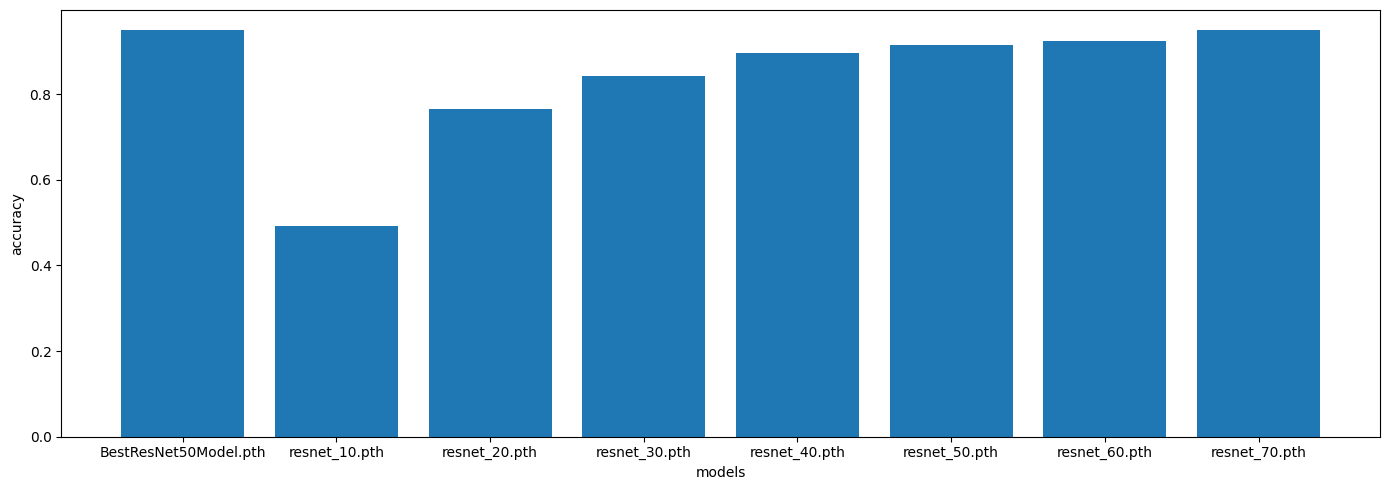

[0.9498607242339833, 0.49303621169916434, 0.766016713091922, 0.8440111420612814, 0.8969359331476323, 0.9164345403899722, 0.924791086350975, 0.9498607242339833]


In [23]:
plt.figure(figsize=(14, 5))
plt.bar(model_list, accuracies)
plt.xlabel("models")
plt.ylabel("accuracy")
plt.tight_layout()
plt.show()
print(accuracies)